In [10]:
import pandas as pd
import json
import requests
from urllib.parse import quote
%matplotlib inline 

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS Crime_Rate ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community LIMIT 10000")

resp = requests.get(soql).json()

crime_total = pd.DataFrame(resp)

# Get rid of the redundant decimal places 
crime_total.Crime_Rate = crime_total.Crime_Rate.astype(float)
crime_total.round(1) 

#ATTENTION HERE: problem with NaN remains unsolved!!!!
crime_total.dropna(axis = 0, how = "any", inplace = True)   
crime_total.head() 


,Community,Crime_Rate
0,0,6.0
1,1,5615.4
2,10,1614.2
3,11,1478.8
4,12,689.6


In [14]:
# Get socioeconomics data 
socioeconomics = pd.read_csv("data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv", index_col = ['Community Area Number']) 

# Merge crime data on socioeconomics data using Communty Area Number 
crime_total.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_total.set_index('Community Area Number')

mix_total = pd.DataFrame.join(crime_total, socioeconomics)
mix_total.dropna(axis = 0, how = "any", inplace = True)  
mix_total

,Community Area Number,Crime_Rate,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
1,1,5615.4,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939.0,39.0
2,10,1614.2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040.0,46.0
3,11,1478.8,Uptown,3.8,24.0,8.9,11.8,22.2,35787.0,20.0
4,12,689.6,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524.0,17.0
5,13,1247.8,North Center,0.3,7.5,5.2,4.5,26.2,57123.0,6.0
6,14,3398.2,Lake View,1.1,11.4,4.7,2.6,17.0,60058.0,5.0
7,15,4842.6,Lincoln Park,0.8,12.3,5.1,3.6,21.5,71551.0,2.0
8,16,4468.6,Near North Side,1.9,12.9,7.0,2.5,22.6,88669.0,1.0
9,17,2415.6,Edison Park,1.1,3.3,6.5,7.4,35.3,40959.0,8.0
10,18,929.4,Norwood Park,2.0,5.4,9.0,11.5,39.5,32875.0,21.0


In [45]:
list(mix_total) 

['Community Area Number',
 'Crime_Rate',
 'COMMUNITY AREA NAME',
 'PERCENT OF HOUSING CROWDED',
 'PERCENT HOUSEHOLDS BELOW POVERTY',
 'PERCENT AGED 16+ UNEMPLOYED',
 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'PERCENT AGED UNDER 18 OR OVER 64',
 'PER CAPITA INCOME ',
 'HARDSHIP INDEX']

In [16]:
# Get into the regression

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/Users/Yangdi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
# First look at the effect of hardship index on crime rate 

crime_hardship = mix_total[['HARDSHIP INDEX','Crime_Rate']] 
crime_hardship.head() 

,HARDSHIP INDEX,Crime_Rate
1,39.0,5615.4
2,46.0,1614.2
3,20.0,1478.8
4,17.0,689.6
5,6.0,1247.8


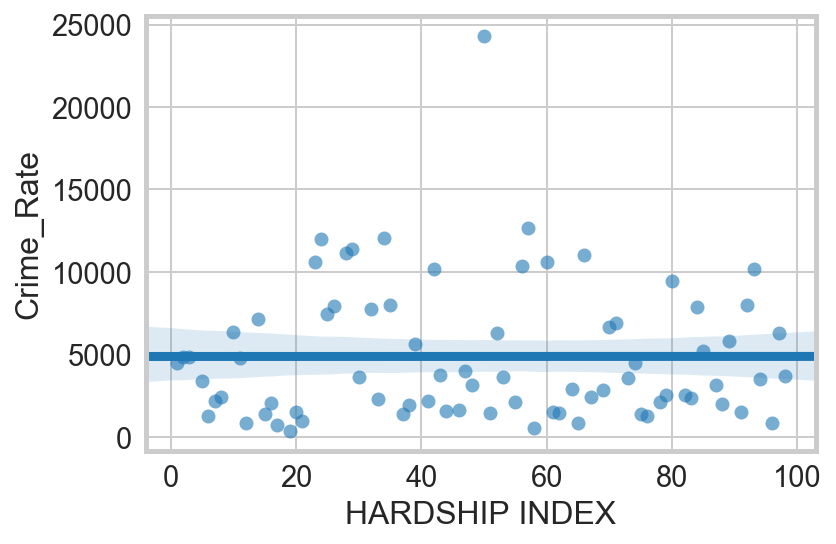

In [25]:
sns.regplot(x = 'HARDSHIP INDEX', y = 'Crime_Rate', data = crime_hardship, scatter_kws = {"alpha" : 0.6}); 

In [37]:
# Notice that there is a dot especially higher than all the others

mix_total[mix_total.Crime_Rate >= 20000]  

# So that outlier is Montclaire. 

,Community Area Number,Crime_Rate,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
18,25,24329.2,Montclaire,8.1,15.3,13.8,23.5,38.6,22014.0,50.0


In [30]:
ols_cr_hard = smf.ols(formula = "CR ~ H",
              data = crime_hardship.rename(columns = {"HARDSHIP INDEX":"H","Crime_Rate":"CR"})) 
model_cr_hard = ols_cr_hard.fit()
model_cr_hard.summary() 

# the coefficient for hardship index in not statistically significant 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     CR   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                 2.939e-06
Date:                Thu, 30 Nov 2017   Prob (F-statistic):              0.999
Time:                        17:08:09   Log-Likelihood:                -749.56
No. Observations:                  77   AIC:                             1503.
Df Residuals:                      75   BIC:                             1508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4872.3766    945.818      5.151      0.000    2988.210    6756.543
H              0.0284     16.557      0.002      0.999     -32.954      33.011
==============================================================================
Omnibus:                       40.648   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.204
Skew:                           1.744   Prob(JB):                     4.32e-25
Kurtosis:                       7.775   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
### So generally speaking, since hardship index consists too much information about the socioeconomic status, it is not an ideal choice for us to explore the reason why different communities have different crime rates.

#### Next, we will turn into different aspects of socioeconomic indicators. 

In [38]:
### First, we choose to look at the "poverty level". And we predict that there is a statistically significant positive relation between "PERCENT HOUSEHOLDS BELOW POVERTY" and crime rate. 

crime_poverty = mix_total[['PERCENT HOUSEHOLDS BELOW POVERTY','Crime_Rate']] 
crime_poverty.head() 

,PERCENT HOUSEHOLDS BELOW POVERTY,Crime_Rate
1,23.6,5615.4
2,17.2,1614.2
3,24.0,1478.8
4,10.9,689.6
5,7.5,1247.8


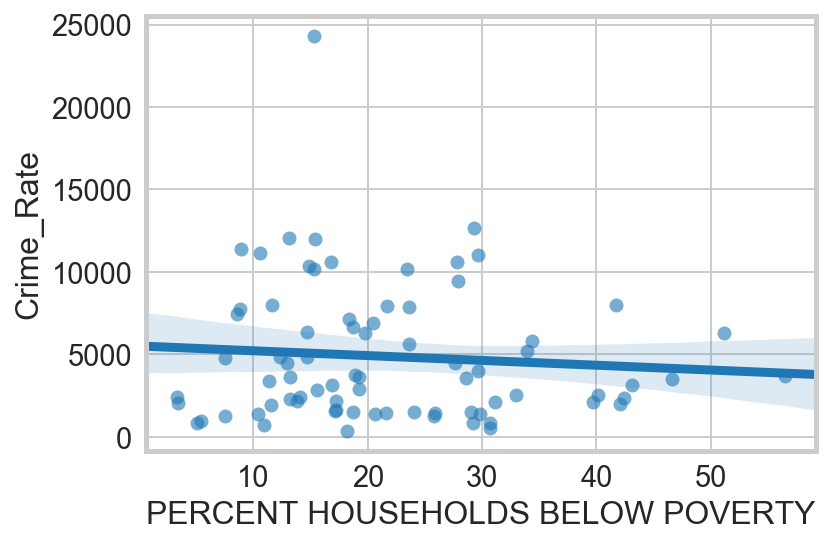

In [39]:
sns.regplot(x = 'PERCENT HOUSEHOLDS BELOW POVERTY', y = 'Crime_Rate', data = crime_poverty, scatter_kws = {"alpha" : 0.6}); 

In [41]:
crime_crowd = mix_total[['PERCENT OF HOUSING CROWDED','Crime_Rate']] 
crime_crowd.head()

,PERCENT OF HOUSING CROWDED,Crime_Rate
1,7.7,5615.4
2,7.8,1614.2
3,3.8,1478.8
4,3.4,689.6
5,0.3,1247.8


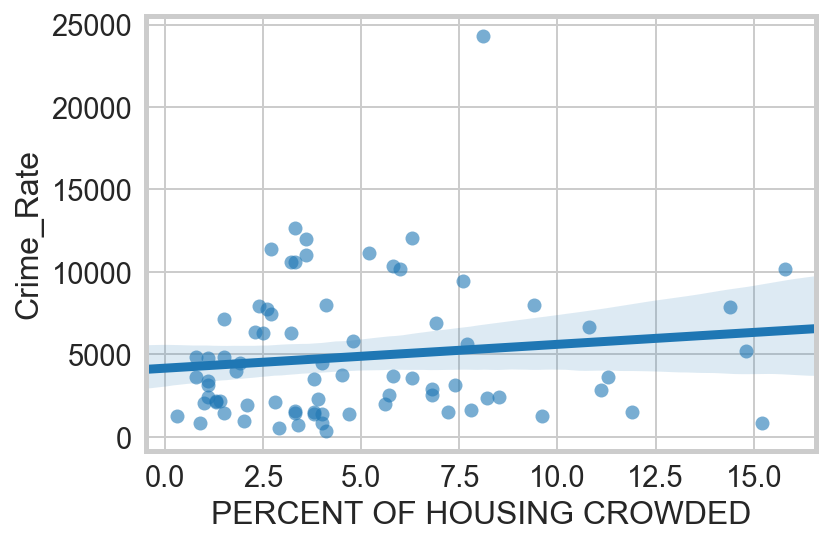

In [42]:
sns.regplot(x = 'PERCENT OF HOUSING CROWDED', y = 'Crime_Rate', data = crime_crowd, scatter_kws = {"alpha" : 0.6});

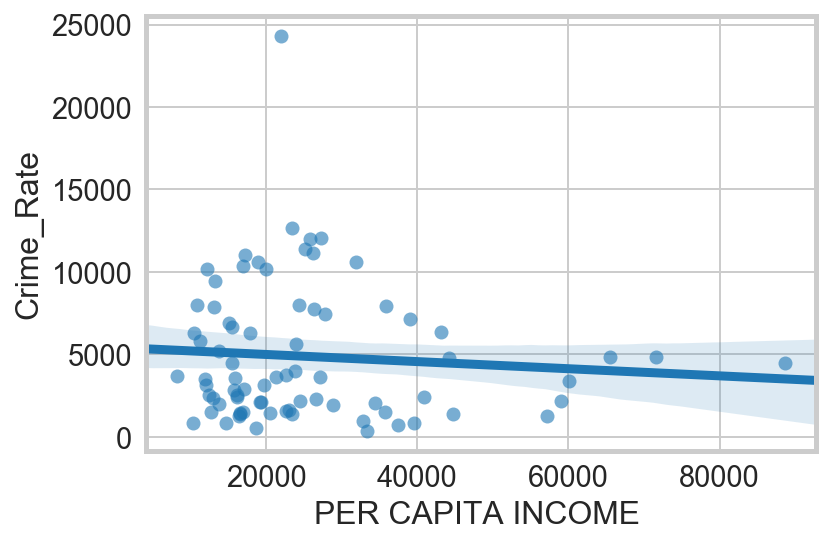

In [47]:
crime_income = mix_total[['PER CAPITA INCOME ','Crime_Rate']] 
sns.regplot(x = 'PER CAPITA INCOME ', y = 'Crime_Rate', data = crime_income, scatter_kws = {"alpha" : 0.6});

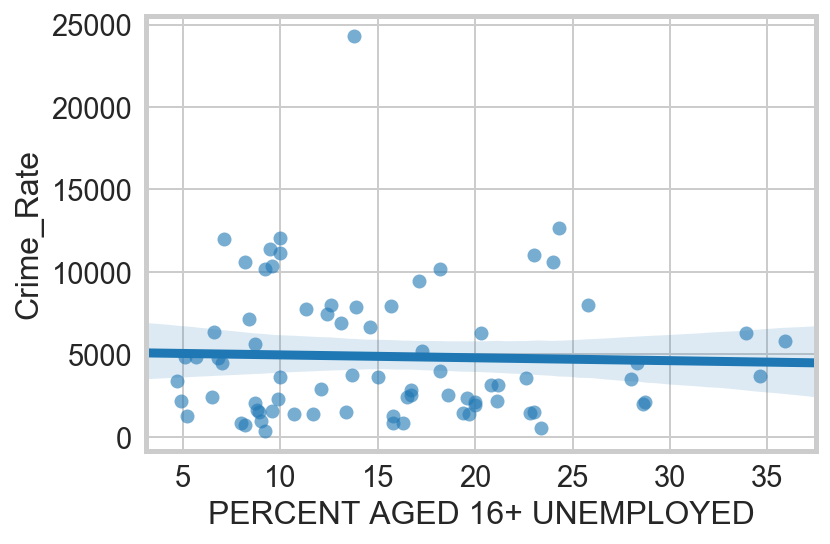

In [48]:
crime_employ = mix_total[['PERCENT AGED 16+ UNEMPLOYED','Crime_Rate']] 
sns.regplot(x = 'PERCENT AGED 16+ UNEMPLOYED', y = 'Crime_Rate', data = crime_employ, scatter_kws = {"alpha" : 0.6});

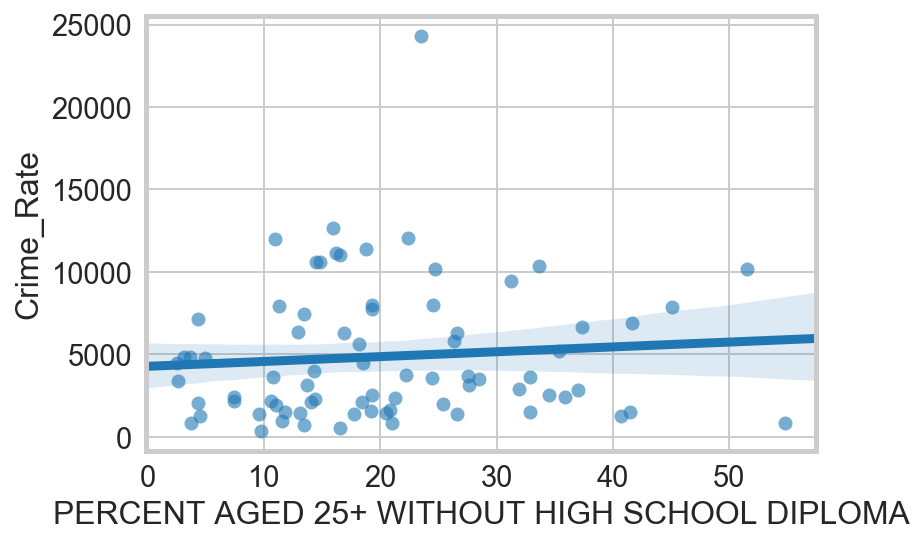

In [49]:
crime_edu = mix_total[['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA','Crime_Rate']] 
sns.regplot(x = 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', y = 'Crime_Rate', data = crime_edu, scatter_kws = {"alpha" : 0.6});


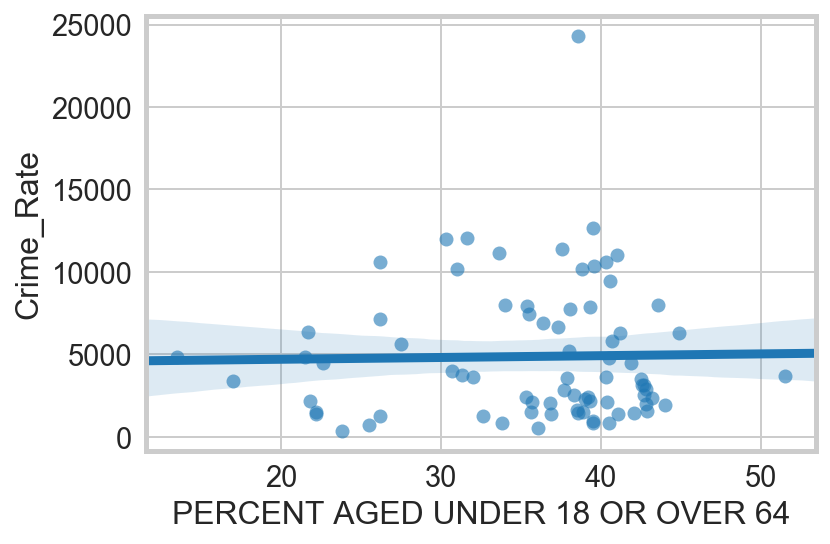

In [50]:
crime_age = mix_total[['PERCENT AGED UNDER 18 OR OVER 64','Crime_Rate']] 
sns.regplot(x = 'PERCENT AGED UNDER 18 OR OVER 64', y = 'Crime_Rate', data = crime_age, scatter_kws = {"alpha" : 0.6});

In [52]:
list(mix_total)

['Community Area Number',
 'Crime_Rate',
 'COMMUNITY AREA NAME',
 'PERCENT OF HOUSING CROWDED',
 'PERCENT HOUSEHOLDS BELOW POVERTY',
 'PERCENT AGED 16+ UNEMPLOYED',
 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'PERCENT AGED UNDER 18 OR OVER 64',
 'PER CAPITA INCOME ',
 'HARDSHIP INDEX']

In [55]:
ols = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age +Income",
              data = mix_total.rename(columns = {"Crime_Rate"                                 : "Crime", 
                                                 "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                 "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                 "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                 "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                 "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                 "PER CAPITA INCOME "                         : "Income",}))
model = ols.fit()
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Crime   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.6378
Date:                Thu, 30 Nov 2017   Prob (F-statistic):              0.700
Time:                        17:43:56   Log-Likelihood:                -747.51
No. Observations:                  77   AIC:                             1509.
Df Residuals:                      70   BIC:                             1525.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8898.9733   5867.767      1.517      0.134   -2803.918    2.06e+04
Crowd        316.6574    292.424      1.083      0.283    -266.563     899.878
Poverty      -97.4552     76.924     -1.267      0.209    -250.875      55.965
Unemp         76.0550    141.139      0.539      0.592    -205.437     357.547
Edu          -71.4104    103.442     -0.690      0.492    -277.719     134.898
Age          -49.9195    115.733     -0.431      0.668    -280.742     180.903
Income        -0.0546      0.068     -0.806      0.423      -0.190       0.081
==============================================================================
Omnibus:                       32.831   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.675
Skew:                           1.478   Prob(JB):                     1.66e-16
Kurtosis:                       6.731   Cond. No.                     3.67e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.67e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

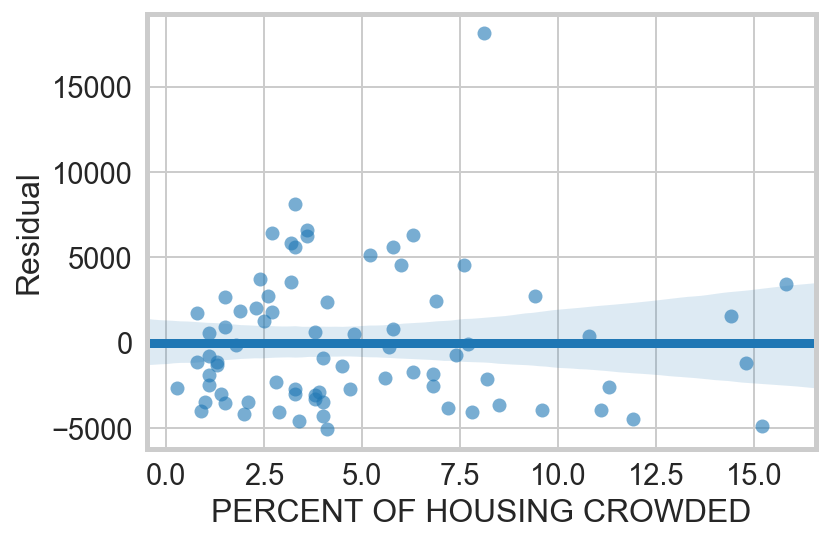

In [57]:
sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.6});

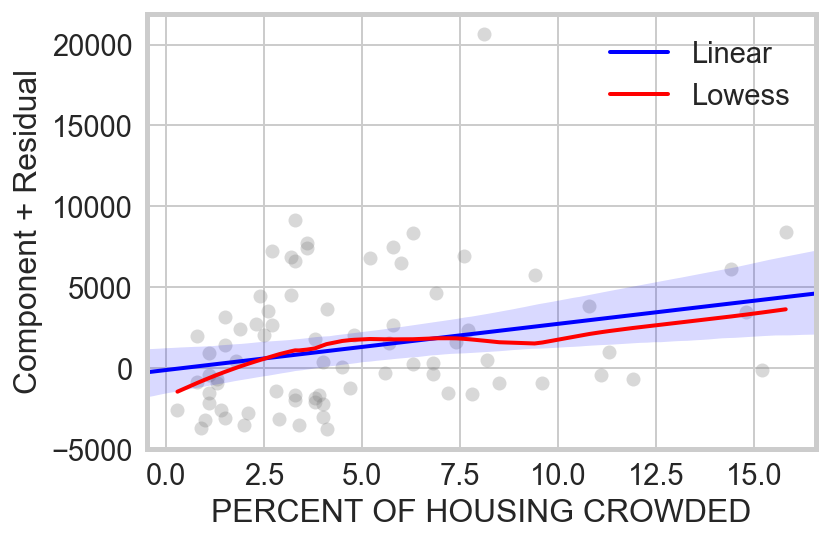

In [62]:
chc = pd.Series(name = "Component + Residual", data = model.resid + mix_total["PERCENT OF HOUSING CROWDED"] * model.
                params["Crowd"])
ax = sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = chc, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.3, "color" : "grey"})
sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = chc, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.3, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = chc, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend()